# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [2]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import numpy as np
import pandas as pd
import time

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import List, Union
import shutil

In [6]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [7]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [8]:
global_train_hist = pd.DataFrame()
runs_best_solution_history = {}
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)
print(f"Total services: {len(supply.services)}")

       Number of Services
AVLO                    4
IRYO                   10
AVE                     6
OUIGO                   5
Total services: 25


Services:  25


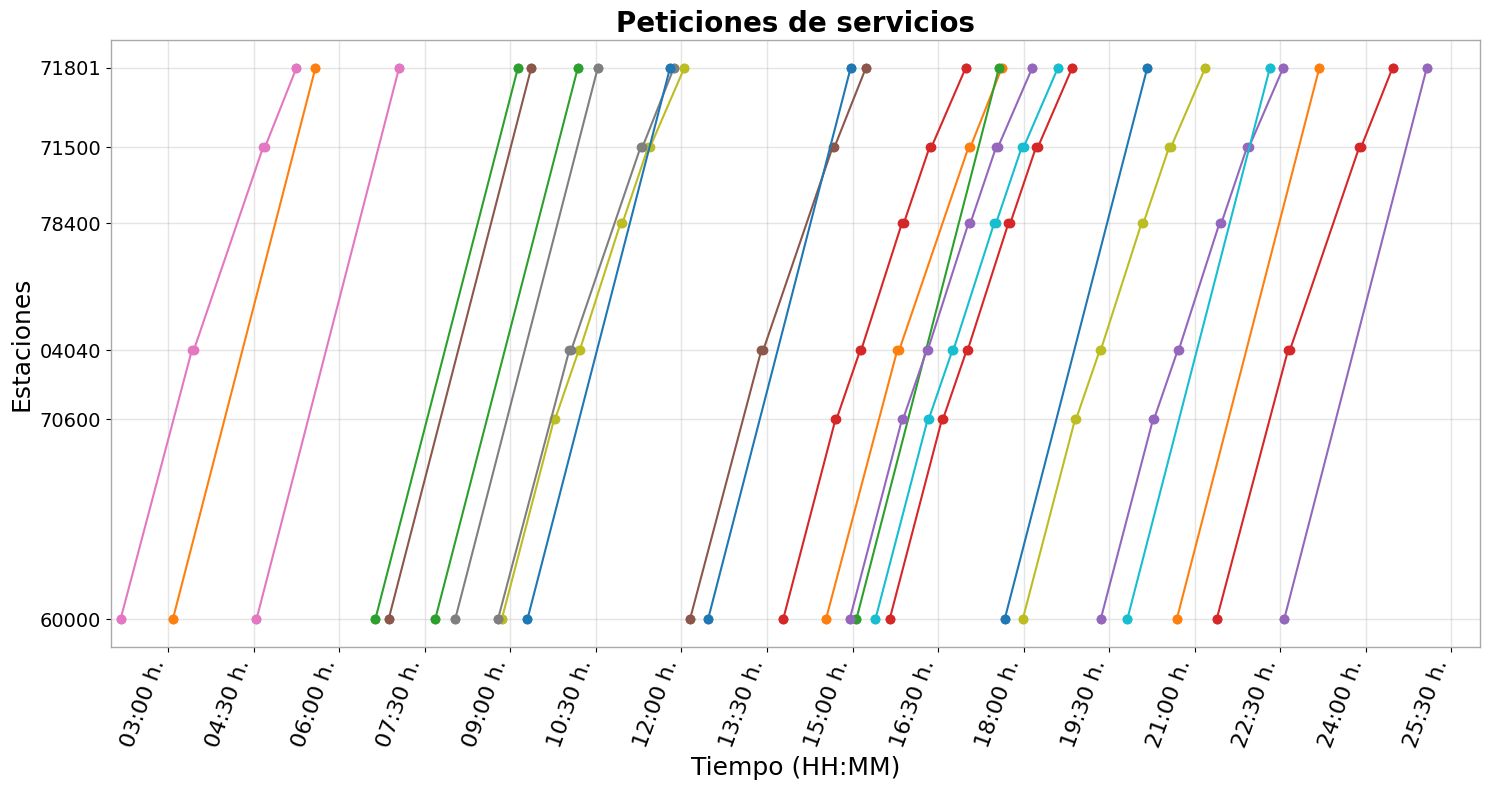

In [9]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(requested_schedule)
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [10]:
runs = 5
population = 20
iters = 50
chaotic = True
verbosity = False

pr = profile.Profile()
pr.enable()

for r in tqdm(range(1, runs + 1)):
    sm = RevenueMaximization(requested_schedule=requested_schedule,
                             revenue_behaviour=revenue_behaviour,
                             line=line,
                             safe_headway=10)

    gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                   is_feasible=sm.feasible_services_times,
                   custom_repair=sm.custom_repair,
                   r_dim=len(sm.boundaries.real),
                   d_dim=0,
                   boundaries=sm.boundaries)

    training_history = gsa_algo.optimize(population_size=population,
                                         iters=iters,
                                         chaotic_constant=chaotic,
                                         repair_solution=True,
                                         initial_population=sm.get_initial_population(population),
                                         verbose=verbosity,
                                         save_population=True)

    training_history.insert(0, "Run", r)
    training_history['Discrete'] = [sm.best_solution.discrete for _ in range(len(training_history))]
    global_train_hist = pd.concat([global_train_hist, training_history], axis=0)

    runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
    
pr.disable()
pr.dump_stats('profile.pstat')

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
df_population = gsa_algo.population_history

experiments = [i for i in range(0, len(df_population), 10)]

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

df_boxplot = pd.DataFrame()

for exp in experiments:
    exp_data = []
    row = df_population.iloc[exp]
    
    # Get list of values in cells of first row with column name 'real_*'
    row_real = [row[col] for col in row.index if 'real_' in col]
    
    for r_sol in row_real:
        solution_gsa = Solution(real=r_sol, discrete=np.array([]))
        fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
        exp_data.append(fitness)
    
    # Add new column to df_boxplot
    df_boxplot[f'Iteration {exp}'] = exp_data
    
df_boxplot

,Iteration 0,Iteration 10,Iteration 20,Iteration 30,Iteration 40
0,3575.202876,3725.050556,3799.557556,3819.667954,3819.667954
1,3617.426402,3741.035238,3803.007656,3819.667954,3819.667954
2,3619.779350,3740.801074,3801.730146,3819.667954,3819.667954
3,3674.168943,3757.533709,3803.007656,3819.667954,3819.667954
4,3711.472181,3759.854686,3801.730146,3819.667954,3819.667954
5,3602.775946,3748.812783,3795.075587,3819.667954,3819.667954
6,3668.762483,3759.175371,3792.373217,3819.667954,3819.667954
7,3649.068562,3738.955663,3799.863424,3819.667954,3819.667954
8,3622.958672,3747.473900,3803.970185,3819.667954,3819.667954
9,3652.366775,3739.243380,3801.730146,3819.667954,3819.667954


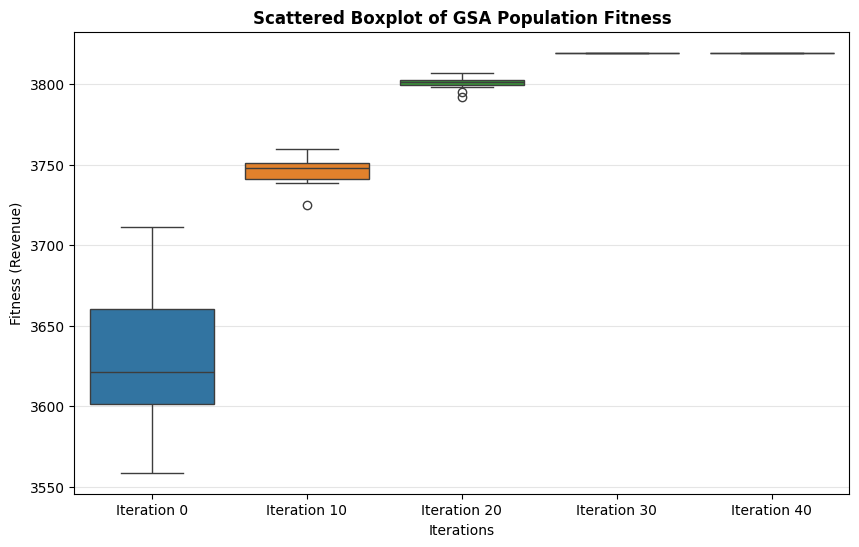

In [25]:
# Scattered boxplot of experiments

sns_box_plot(df=df_boxplot,
             title="Scattered Boxplot of GSA Population Fitness",
             x_label="Iterations",
             y_label="Fitness (Revenue)",
             save_path=Path('../figures/scattered_boxplot.pdf'))

In [26]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

run_grouped_df = global_train_hist.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),AVLO,AVE,OUIGO,IRYO
3,4,3842.788236,11.682364,15,14.0,98.0,50.0 %,60.0 %,50.0 %,80.0 %
2,3,3837.320728,11.317862,15,9.0,109.0,50.0 %,60.0 %,50.0 %,80.0 %
4,5,3819.690505,11.879296,15,8.0,118.0,50.0 %,60.0 %,50.0 %,80.0 %
1,2,3795.903094,11.202752,15,12.0,122.0,50.0 %,60.0 %,50.0 %,80.0 %
0,1,3762.915775,11.386971,15,8.0,136.0,50.0 %,60.0 %,50.0 %,80.0 %


In [27]:
# Global status
print("Global GSA status:")

# Execution time (mean and std.)
run_times = run_grouped_df['ExecutionTime'].last()
print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

# Revenue (mean and std.)
run_revenues = run_grouped_df['Fitness'].last()
print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

# Scheduled trains (mean and std.)
run_trains = run_grouped_df['Discrete'].last().apply(sum)
print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

runs_best_solution_history = dict(sorted(runs_best_solution_history.items(),
                                         key=lambda x: x[1][1]))

q2_solution_index = np.floor(runs // 2).astype(int)
gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]

print(f"\tMedian solution: Run {gsa_solution[0]}")
max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")

Global GSA status:
	Total execution time: 57.4692 s.
	Execution Time (by run) - Mean: 11.4938 s. - Std: 0.2789 s.
	Revenue - Mean: 3811.7237 - Std: 32.8489
	Scheduled Trains - Mean: 15.0 - Std: 0.0
	Median solution: Run 5
	Max Revenue: 6011.5 - WARNING!: Scheduling all services could not be feasible


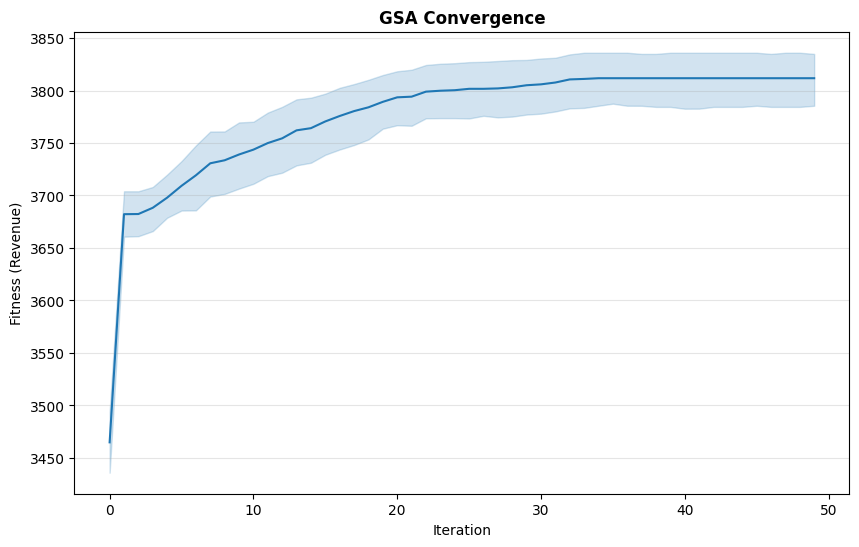

In [28]:
# GSA Convergence plot
sns_line_plot(df=global_train_hist,
              x_data="Iteration",
              y_data="Fitness",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)",
              save_path=Path('../figures/gsa_convergence.pdf'))

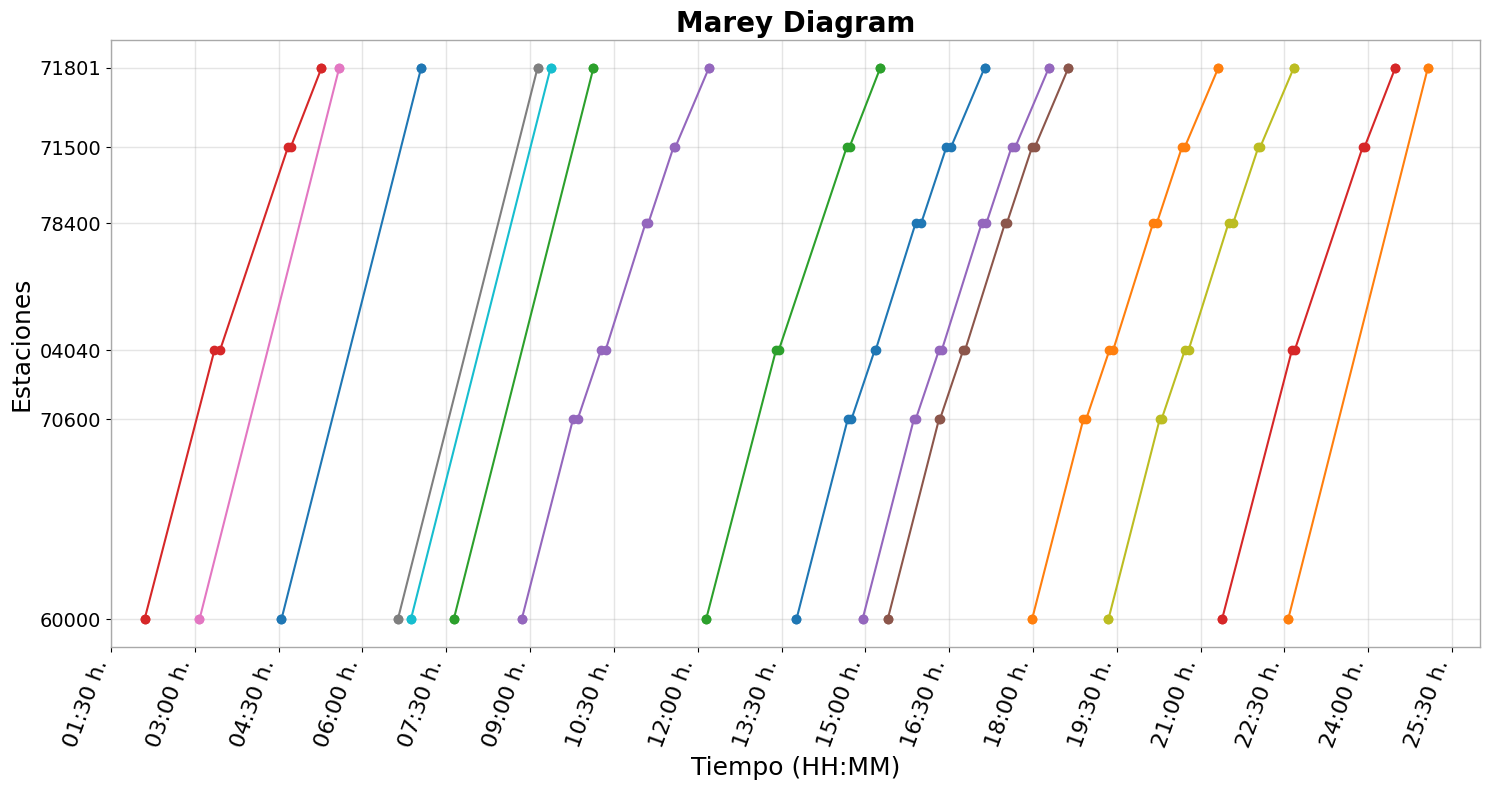

In [31]:
services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 5405
	Status: User bought a service which was not the one with the best utility. - Passengers: 2372
	Status: User bought the ticket with best utility. - Passengers: 931
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  3303
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 239 - Percentage: 7.24 %
		Seat: Turista - Passengers: 1977 - Percentage: 59.85 %
		Seat: TuristaPlus - Passengers: 1087 - Percentage: 32.91 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  3303
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 20
			Seat: Turista - Number of tickets sold: 61
			Seat: TuristaPlus - Number of tickets sold: 69
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 14
			Seat: Turista - Number of tic

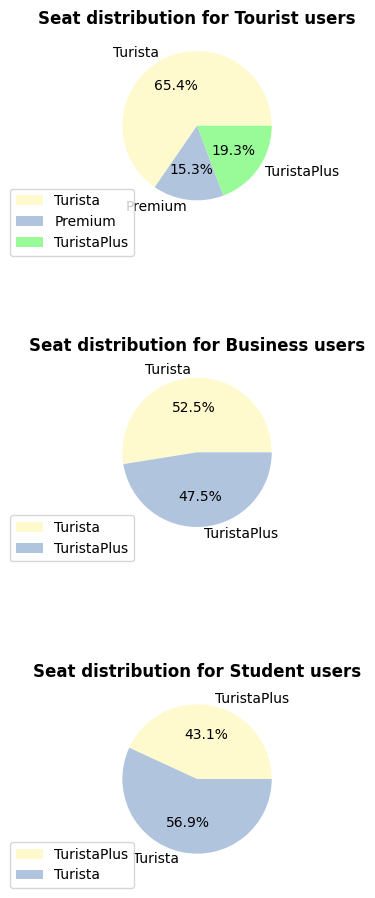

In [17]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_path,
                path_config_demand=demand_config_path)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'), departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_path)

kernel_plotter.plotter_data_analysis()
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!
